# Deep Financial Market Modeling with LSTM - Part 1
### CSCI 4210 - Simulation and Modeling
#### Matthew Wicker

In this notebook, we will create a univariate LSTM Model for historical stock prices.

### Getting started - Download your own data:

#### • Go to - https://finance.yahoo.com/
#### • Search a stock that you would like to create a model for
#### • Click on 'History'
#### • Set history to 'max'
#### • Click apply and then download
##### (If you have cloned the repository from github you can skip this and use one of the included csv files)

In [1]:
import sys
sys.path.append('/usr/local/lib/python2.7/site-packages')

import csv
import numpy as np
from __future__ import print_function
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.cross_validation import  train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (16, 10)
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os


#===========================================================
#          We have set these for reproducibility
#===========================================================

np.random.seed(5)
look_back = 7
epochs = 60
batch_size = 32

#===========================================================
#      Constants which define the stock you want to use
#===========================================================

# Here is the path to your finacial data from Yahoo:
STOCK_TO_USE = "AAPL"
DATA_PATH = "FinData/" + STOCK_TO_USE + ".csv"
MODEL_JSON_PATH = "FinModels/" + STOCK_TO_USE + ".json"
MODEL_WEIGHT_PATH = "FinModels/" + STOCK_TO_USE + ".h5"

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Reading in Data
 This section is largely unncessarry in the context of our our problem; however, we have included this basic structure in case someone wants to apply this approach to a different dataset or different types of data.

In [2]:
# Here are the basic values of each stock that we have information on
class date:
    def __init__(self):
        self.date = "NaN"
        self.open = 0.0
        self.high = 0.0
        self.low = 0.0
        self.close = 0.0
        self.adj = 0.0
        self.volume = 0.0
    def reinit(self, date, op, high, low, close, adj, vol):
        self.date = date
        self.open = float(op)
        self.high = float(high)
        self.low = float(low)
        self.close = float(close)
        self.adj = float(adj)
        self.volume = float(vol)
        
data_entries = []
print ("Opening File: %s"%(DATA_PATH))
with open(DATA_PATH, 'rb') as f:
    reader = csv.reader(f)
    for i, row in enumerate(reader):
        if('null' in row): continue;
        if(i == 0): continue;
        temp_date = date()
        temp_date.reinit(row[0], row[1], row[2], row[3], row[4], row[5], row[6])
        data_entries.append(temp_date)
print("Done reading file")

Opening File: FinData/AAPL.csv
Done reading file


###  Plot some of this data
First, we format each value as a numpy array and then we plot it using matplotlib

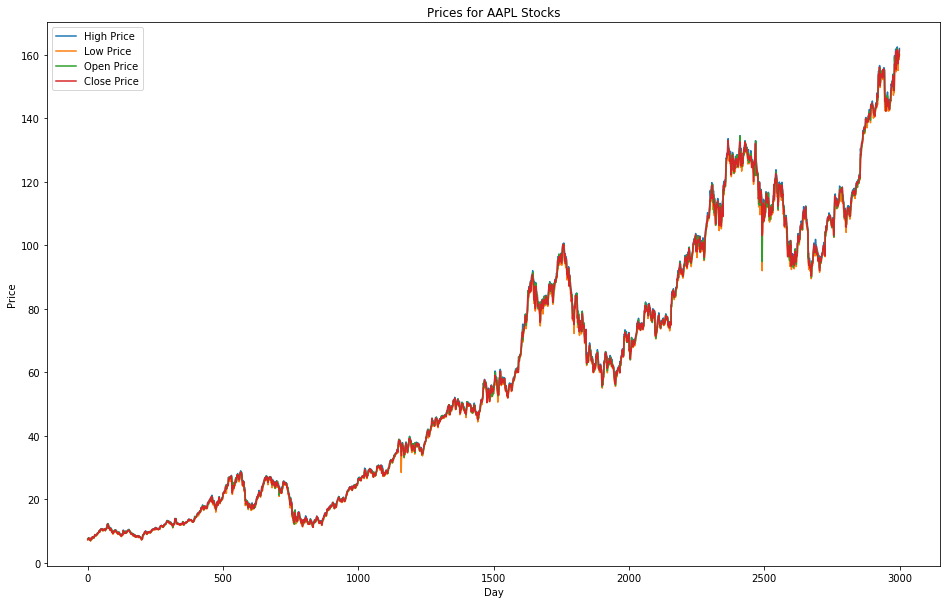

In [3]:
dates_of_data = np.asarray([i.date for i in data_entries])
open_of_data = np.asarray([i.open for i in data_entries])
close_of_data = np.asarray([i.close for i in data_entries])
high_of_data = np.asarray([i.high for i in data_entries])
low_of_data = np.asarray([i.low for i in data_entries])

dates_of_data = dates_of_data[-3000:]
open_of_data = open_of_data[-3000:]
close_of_data = close_of_data[-3000:]
high_of_data = high_of_data[-3000:]
low_of_data = low_of_data[-3000:]

plt.title("Prices for %s Stocks"%(STOCK_TO_USE))
plt.xlabel("Day")
plt.ylabel("Price")
h, = plt.plot(high_of_data, label='High Price')
l, = plt.plot(low_of_data, label='Low Price')
o, = plt.plot(open_of_data, label='Open Price')
c, = plt.plot(close_of_data, label='Close Price')
plt.legend(handles=[h, l, o, c])
plt.show()

## Conversion to Pandas Dataframe

For LSTMs (especially multivariate LSTMs), it is very popular to use the 'pandas' package. If you would like to convert the work we have done above to pandas, then you can use the code below. 

In [4]:
"""
import pandas

dates = range(len(open_of_data))
stock_label = ["STCK" for i in range(len(open_of_data))]

reformatted_data = np.asarray([dates, stock_label, open_of_data, close_of_data, low_of_data, high_of_data])
reformatted_data = np.transpose(reformatted_data)

#dtype = [('Date','string'), ('Label','float32'), ('open','float32'), ('close','float32'), ('low','float32'), ('high','float32')]
values = reformatted_data#numpy.zeros(20, dtype=dtype)
index = [str(i) for i in range(1, len(values)+1)]

apple = pandas.DataFrame(values, index=index)
df.columns = ['date', 'symbol', 'open', 'close', 'low', 'high']
print (df)
"""

'\nimport pandas\n\ndates = range(len(open_of_data))\nstock_label = ["STCK" for i in range(len(open_of_data))]\n\nreformatted_data = np.asarray([dates, stock_label, open_of_data, close_of_data, low_of_data, high_of_data])\nreformatted_data = np.transpose(reformatted_data)\n\n#dtype = [(\'Date\',\'string\'), (\'Label\',\'float32\'), (\'open\',\'float32\'), (\'close\',\'float32\'), (\'low\',\'float32\'), (\'high\',\'float32\')]\nvalues = reformatted_data#numpy.zeros(20, dtype=dtype)\nindex = [str(i) for i in range(1, len(values)+1)]\n\napple = pandas.DataFrame(values, index=index)\ndf.columns = [\'date\', \'symbol\', \'open\', \'close\', \'low\', \'high\']\nprint (df)\n'

## Test-Train Datasplit

Here we are going to define the price that we would like to predict (i.e., open, close, high, low). We also split that data into testing and training information. 

In [5]:
stock_prices = open_of_data
stock_prices = stock_prices.reshape(len(stock_prices), 1)


# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
stock_prices = scaler.fit_transform(stock_prices)

train_size = int(len(stock_prices) * 0.67)
test_size = len(stock_prices) - train_size
train, test = stock_prices[0:train_size,:], stock_prices[train_size:len(stock_prices),:]

print('Split data into training set and test set... Number of training samples/ test samples:', len(train), len(test))

def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# convert stock price data into time series dataset
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input of the LSTM to be format [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

print("Done with split")

Split data into training set and test set... Number of training samples/ test samples: 2010 990
Done with split


## Now, we define the model 
Here is the definition of the Keras model. This is a very simple model. By all means, get creative with the structure of the network. 

In [6]:
# create and fit the LSTM network
layers = [1,look_back,1]
model = Sequential()
d = 0.3
model = Sequential()    
model.add(LSTM(32, input_shape=(layers[1], layers[0]), return_sequences=False))
model.add(Dropout(d))
        
model.add(Dense(4,kernel_initializer="uniform",activation='relu'))        
model.add(Dense(1,kernel_initializer="uniform",activation='linear'))

model.compile(loss='mse', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 4,489
Trainable params: 4,489
Non-trainable params: 0
_________________________________________________________________


## Train your model
After you are satisfied with the structure of your network (and it successfully compiles), you can train the network
on the data that we have prepared.

In [7]:
model.fit(trainX, trainY, nb_epoch=epochs, verbose=1, batch_size=batch_size)

/home/mwicker/.local/lib/python2.7/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/60
2002/2002 [==============================] - 0s - loss: 0.0470     
Epoch 2/60
2002/2002 [==============================] - 0s - loss: 0.0091     
Epoch 3/60
2002/2002 [==============================] - 0s - loss: 0.0014     
Epoch 4/60
2002/2002 [==============================] - 0s - loss: 0.0012     
Epoch 5/60
2002/2002 [==============================] - 0s - loss: 0.0011     
Epoch 6/60
2002/2002 [==============================] - 0s - loss: 0.0010     
Epoch 7/60
2002/2002 [==============================] - 0s - loss: 7.7590e-04     
Epoch 8/60
2002/2002 [==============================] - 0s - loss: 7.6965e-04     
Epoch 9/60
2002/2002 [==============================] - 0s - loss: 6.5915e-04     
Epoch 10/60
2002/2002 [==============================] - 0s - loss: 6.9674e-04     
Epoch 11/60
2002/2002 [==============================] - 0s - loss: 6.8107e-04     
Epoch 12/60
2002/2002 [==============================] - 0s - loss: 6.8605e-04     
Epoch 13/60
2002/2002 [==

## Predictions
Here we are going to create predictions based on the trained model, and we will evaluate the RMSD of the predictions

In [8]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions and targets to unscaled
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainY = trainY.reshape(len(trainY[0]), 1)
testY = testY.reshape(len(testY[0]), 1)
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


# shift predictions of training data for plotting
trainPredictPlot = np.empty_like(stock_prices)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift predictions of test data for plotting
testPredictPlot = np.empty_like(stock_prices)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(stock_prices)-1, :] = testPredict

Train Score: 1.66 RMSE
Test Score: 3.33 RMSE


## Some fun plots.

In the first of the below we show both the prediction of the test and train portion. Really, you should be concerned with the accuracy of your 'test' prediction. 

In the second, we show just the 'test' prediction portion. This should be a good guide for how well your model will do in the real world.

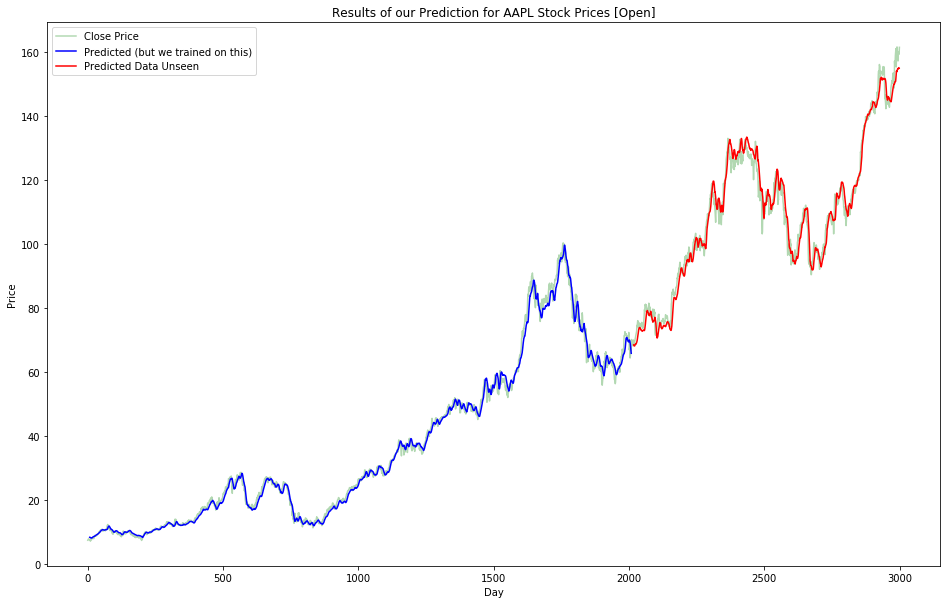

In [9]:
# plot baseline and predictions
plt.title("Results of our Prediction for %s Stock Prices [Open]"%(STOCK_TO_USE))
plt.xlabel("Day")
plt.ylabel("Price")

c, = plt.plot(close_of_data, label='Close Price',alpha=0.3, color='g')
predict_train, = plt.plot(trainPredictPlot, label='Predicted (but we trained on this)', color='b')
predict_test, = plt.plot(testPredictPlot, label='Predicted Data Unseen', color='r')
plt.legend(handles=[c, predict_train, predict_test])
plt.show()

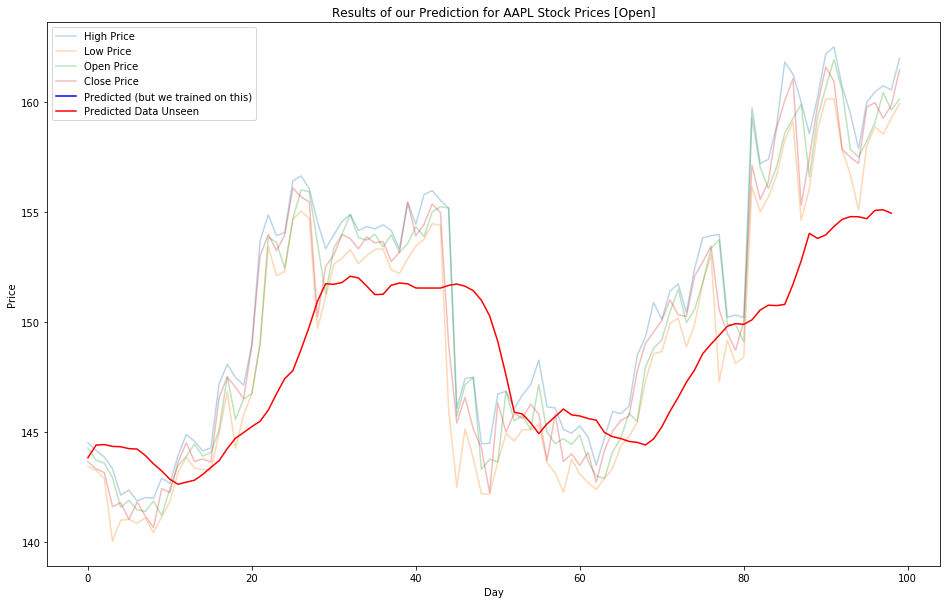

In [10]:
# plot baseline and predictions
plt.clf()
plt.title("Results of our Prediction for %s Stock Prices [Open]"%(STOCK_TO_USE))
plt.xlabel("Day")
plt.ylabel("Price")
test_size = 100
h, = plt.plot(high_of_data[-test_size:], label='High Price', alpha=0.3)
l, = plt.plot(low_of_data[-test_size:], label='Low Price', alpha=0.3)
o, = plt.plot(open_of_data[-test_size:], label='Open Price', alpha=0.3)
c, = plt.plot(close_of_data[-test_size:], label='Close Price',alpha=0.3)
predict_test, = plt.plot(testPredictPlot[-test_size:], label='Predicted Data Unseen', color='r')
plt.legend(handles=[h, l, o, c, predict_train, predict_test])
plt.show()

## Predict what will happen tomorrow

So, with our model trained and evaluated, let's try to decide what will happen tomorrow. 
##### Note, this will ONLY work if you have just downloaded new data for the csv 


In [11]:
jump_point = list(testX[-1])
val = model.predict(np.asarray([jump_point]))
val = testY[-1] * val
print("Based on our model, the price of %s stock one day after %s is somewhere around: %s"%(STOCK_TO_USE, dates_of_data[-1], val[0][0]))

Based on our model, the price of AAPL stock one day after 2017-08-28 is somewhere around: 152.454132231


## Persistance
If you decide that this is a good model, we have included the basif functions that will be able to
save and load models

In [12]:
#the function to save model
def model_save(model_json,model_h5):
    json_model = model.to_json()
    with open(model_json, "w") as f:
        f.write(json_model)
    model.save_weights(model_h5)  
print (MODEL_JSON_PATH, MODEL_WEIGHT_PATH)
model_save(MODEL_JSON_PATH, MODEL_WEIGHT_PATH)

FinModels/AAPL.json FinModels/AAPL.h5


In [13]:
# create and load the LSTM Model
def reload_model():
    layers = [1,look_back,1]
    model = Sequential()
    d = 0.3
    model = Sequential()    
    model.add(LSTM(32, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(4,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))

    model.compile(loss='mse', optimizer='adam')
    model.load_weights(MODEL_WEIGHT_PATH)
    model.compile(loss='mse', optimizer='a
    return model

model = reload_model()

ValueError: You are trying to load a weight file containing 3 layers into a model with 4 layers.